# Kaggle Competition Information


The goal of this Kaggle competition, hosted by Women in Data Science Livermore, was to predict which patients in the dataset will receive metastatic cancer diagnosis within 90 days of screening. According to the competition page, solving this problem is important because "metastatic TNBC is considered the most aggressive TNBC and requires most urgent and timely treatment. Unnecessary delays in diagnosis and subsequent treatment can have devastating effects in these difficult cancers. Differences in the wait time to get treatment is a good proxy for disparities in healthcare access. The primary goal of building these models is to detect relationships between demographics of the patient with the likelihood of getting timely treatment. The secondary goal is to see if environmental hazards impact proper diagnosis and treatment."

This competition targeted those with beginner and intermediate data science skills to "inspire and educate data scientists worldwide, regardless of gender, and to support women in the field" according to the [WiDS Livermore page](https://data-science.llnl.gov/latest/wids-livermore).

More information about the competition, dataset, and results can be found [here](https://www.kaggle.com/competitions/widsdatathon2024-challenge1).

# Solution Walkthrough

This walkthrough was added on March 18th after the project was completed on February 28th. Therefore, it represents an abbreviation of the thought process used to solve the challenge.

First, I imported libraries commonly used for data science: matplotlib, NumPy, and Pandas.

In [74]:
import pandas as pd  # For importing data from the text files containing the data
import matplotlib.pyplot as plt  # For data visualization
import numpy as np  # For a variety of utilities

Next, I read in the training and test data provided from the current directory.

In [75]:
# Read in csv files in the current directory to DataFrames
training = pd.read_csv('training.csv')
test = pd.read_csv('test.csv')

# The training file contains the labels as well, so separate those out and delete them from the training data
trainingLabels = training['DiagPeriodL90D']
training.drop('DiagPeriodL90D', axis = 1, inplace = True)

# Also, the patient IDs in the training data do nothing. They aren't predictors. We only need the patient IDs from the test
# set for reporting.
training.drop('patient_id', axis = 1, inplace = True)
patientIDs_test = test['patient_id']
test.drop('patient_id', axis = 1, inplace = True)

I investigated the data to determine what features are provided and what preprocessing may be necessary

In [76]:
# Loop through the DataFrame columns, count number of NaN instances, and print
for column in training.columns:
    nanInstances = training[column].isna().sum()
    print('For column ' + column + ', there are ' + str(nanInstances) + ' instances of NaN (' + 
         "{:.2f}".format(nanInstances/len(training[column])) + '% of column)')
print('There are', len(training.columns), 'columns in this dataset')

For column patient_race, there are 6385 instances of NaN (0.49% of column)
For column payer_type, there are 1803 instances of NaN (0.14% of column)
For column patient_state, there are 51 instances of NaN (0.00% of column)
For column patient_zip3, there are 0 instances of NaN (0.00% of column)
For column patient_age, there are 0 instances of NaN (0.00% of column)
For column patient_gender, there are 0 instances of NaN (0.00% of column)
For column bmi, there are 8965 instances of NaN (0.69% of column)
For column breast_cancer_diagnosis_code, there are 0 instances of NaN (0.00% of column)
For column breast_cancer_diagnosis_desc, there are 0 instances of NaN (0.00% of column)
For column metastatic_cancer_diagnosis_code, there are 0 instances of NaN (0.00% of column)
For column metastatic_first_novel_treatment, there are 12882 instances of NaN (1.00% of column)
For column metastatic_first_novel_treatment_type, there are 12882 instances of NaN (1.00% of column)
For column Region, there are 5

As the frequencies of NaN are small compared to the length of the columns, it was reasonable to use imputation to replace those values rather than removing affected features.

By inspecting the description of the dataset and the features provided on the competition page (see introduction for the link), I noted that 10 of the features were specific to the patient and their health. The 71 remaining features (disregarding patient ID) are instead specific to where the patient lives. Could I encapsulate this information into the zip code? This could help avoid issues relating to high dimensionality and correlated features, like unnecessary model complexity and overfitting.

In [77]:
# Check that all location-related features are the same for a given zip code value

# Get some zip code value
zipCodeToTest = training['patient_zip3'].iloc[0]
# Get location-specific columns by removing patient-specific columns + zip code
trainingColumns = training.columns
locationFeatures = trainingColumns.drop(['patient_race', 'payer_type', 'patient_state', 'patient_zip3',
                                        'patient_age', 'patient_gender','bmi', 'breast_cancer_diagnosis_code', 
                                        'breast_cancer_diagnosis_desc', 'metastatic_cancer_diagnosis_code', 
                                        'metastatic_first_novel_treatment', 'metastatic_first_novel_treatment_type'])

# Compare output above to number of instances of this particular zip code
print('Count expect to see:', (training[training['patient_zip3'] == zipCodeToTest]['patient_zip3'].value_counts(dropna = False)).to_string(), '\n\n') 

# For rows with a zip code equal to zipCodeToTest, get counts of instances of values
for column in locationFeatures:
    print(training[training['patient_zip3'] == zipCodeToTest][column].value_counts(dropna = False).to_string())

Count expect to see: patient_zip3
924    18 


Region
West    18
Division
Pacific    18
population
31437.75    18
density
1189.5625    18
age_median
30.642857    18
age_under_10
16.014286    18
age_10_to_19
15.542857    18
age_20s
17.614286    18
age_30s
14.014286    18
age_40s
11.614286    18
age_50s
11.557143    18
age_60s
7.571429    18
age_70s
4.0    18
age_over_80
2.1    18
male
49.857143    18
female
50.142857    18
married
36.571429    18
divorced
11.885714    18
never_married
47.114286    18
widowed
4.442857    18
family_size
3.928571    18
family_dual_income
52.228571    18
income_household_median
52996.28571    18
income_household_under_5
3.142857    18
income_household_5_to_10
4.0    18
income_household_10_to_15
6.157143    18
income_household_15_to_20
5.142857    18
income_household_20_to_25
6.271429    18
income_household_25_to_35
10.142857    18
income_household_35_to_50
13.3    18
income_household_50_to_75
20.0    18
income_household_75_to_100
12.742857    18
income_hous

All of the counts match, showing that, for the 18 rows that have this particular zip code, they share the same values for the location-specific features. So, I could go ahead and remove the location-specific features since they're correlated with zip code.

In [78]:
# From the previous cell, the variable locationFeatures contains all the features I want to remove
trimmedTraining = training.copy()
trimmedTesting = test.copy()
trimmedTraining.drop(locationFeatures, axis = 1, inplace = True)
trimmedTesting.drop(locationFeatures, axis = 1, inplace = True)

Then, I set up the preprocessing pipeline. From before, I knew that I had to do some imputation. I noticed there are some columns that have an object type (e.g. patient_race) while others are integers or floats (e.g. patient_zip3), so I had to take two different approaches to process these different types.

Also, I added a scaler to improve algorithm performance and speed up convergence for the numerical types. I started with StandardScaler since it's general purpose. For the categorical types, I used one hot encoding so that I could use ML algorithms that expect numerical input.

In [79]:
# Divide remaining columns into numerical and categorical
num_cols = trimmedTraining.select_dtypes(exclude = 'object').columns
cat_cols = trimmedTraining.select_dtypes(include = 'object').columns

# Import necessary tools from scikit-learn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Pipeline for numerical data that replaces missing values with the mean of the column, subtracts the mean of the column
# from each entry, and divides each entry by the standard deviation of the column (after mean subtraction).
numberPipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scale', StandardScaler())
])

# Pipeline for categorical data that replaces missing values with most common value in the column and one hot encodes
# each entry, ignoring entries in the test data that did not appear in the training data
categoricalPipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('one-hot',OneHotEncoder(handle_unknown='ignore'))
])

# Take the data, apply the appropriate pipeline to the numerical and categorical data, and ignore any columns that
# aren't either (which should be zero since the columns were split by if they were or were not an object dtype) using all
# processors available
col_trans = ColumnTransformer(transformers=[
    ('num_pipeline',numberPipeline,num_cols),
    ('cat_pipeline',categoricalPipeline,cat_cols)
    ],
    remainder='passthrough',
    n_jobs=-1)

I tried a basic logistic regression model and adjusted it from there. Since the competition is scored by ROC using the probabilities of the classification produced and competitors aren't given the whole test set through scoring on the leaderboard until the competition is over, I had to make sure the model was not overfitting and that the confidence scores were reliable.

I raised the max iteration limit to make sure logistic regression could converge properly and wouldn't be stopped by reaching the limit. Although early stopping is a form of regularization, I didn't expect logistic regression would overfit with a higher iteration threshold.

I set the random state so that I obtained the same results each time

I used various measures to get a fuller picture of the model's performance and where it could improve, namely a log loss score, confusion matrix, calibration curve, and cross validation score.

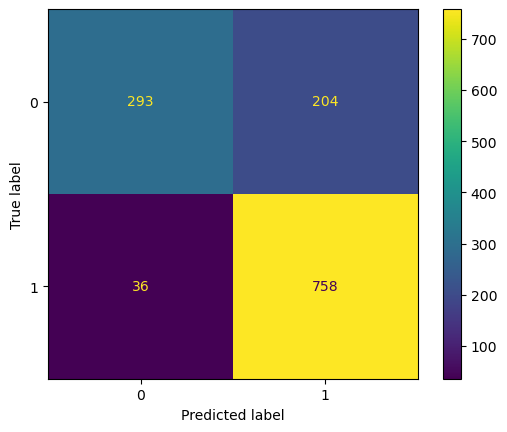

Log loss of predicted probabilities vs true labels: 0.4732370636711795
Cross validation score: [0.81758327 0.79697792 0.8225494  0.81325068 0.80627664]


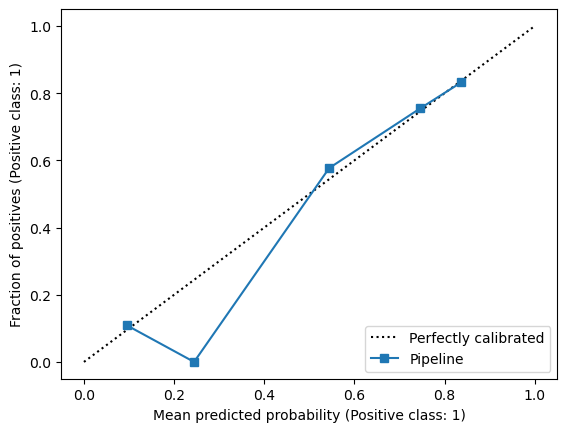

In [82]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, log_loss
from sklearn.calibration import CalibrationDisplay
from sklearn.linear_model import LogisticRegression

# Set random state to avoid variations in results
randomState = 0

# Split the training data into training and testing
X_train, X_test, y_train, y_test = train_test_split(trimmedTraining, trainingLabels, test_size=0.1, random_state = randomState)

# Initialize the logistic regression object
clf = LogisticRegression(random_state=0, max_iter = 1000)

# Define a pipeline that contains both the preprocessing and the model to be fit
clf_pipeline = Pipeline(steps=[
    ('col_trans', col_trans),
    ('model', clf)
])

# Fitting and evaluating the model
clf_pipeline.fit(X_train, y_train)
y_pred = clf_pipeline.predict(X_test)
predsProb = clf_pipeline.predict_proba(X_test)[:, 1]

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()
plt.show()

print('Log loss of predicted probabilities vs true labels:', log_loss(y_test.values, predsProb))

CalibrationDisplay.from_estimator(clf_pipeline, X_test, y_test)

print('Cross validation score:', cross_val_score(clf_pipeline, trimmedTraining, trainingLabels, cv=5))

With this baseline, notably plagued by false positives, I experimented via trial and error with a variety of traditional and deep learning techniques to see which would result in the the best model. In addition, I tried balancing the classes represented in the training set, hyperparameter tuning via grid search, feature selection, regularization, and outlier removal.

Ultimately, the MLP Classifier with a grid search on alpha (regularization parameter) and calibration produced my personal best result, reproduced below with the code to write the  predictions to a text file commented out

Log loss is 0.4655026664423248


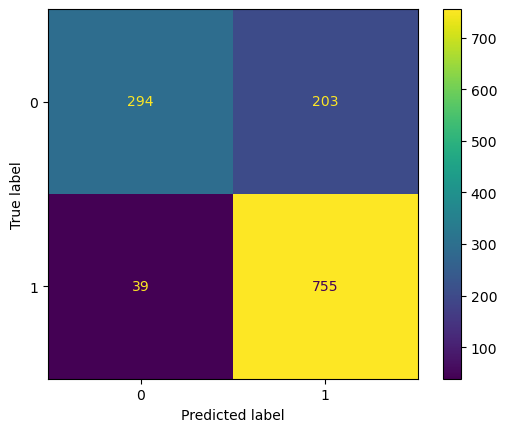

Cross validation score: [0.81758327 0.79620302 0.82177451 0.81247578 0.80666408]


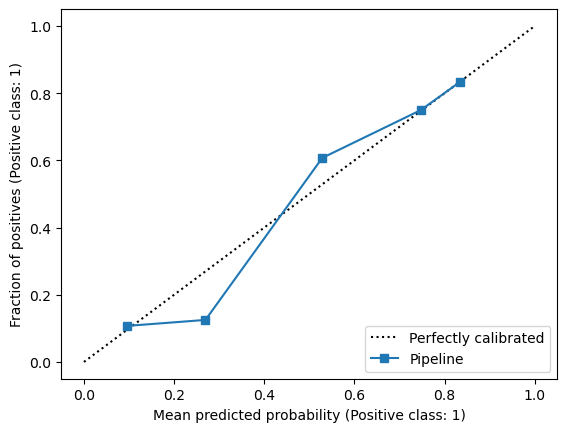

In [81]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

# Initial MLPClassifier object with no alpha specified
clf1 = MLPClassifier(max_iter = 1000, random_state = randomState)

# Use grid search to optimize alpha
bestGrid = GridSearchCV(clf1, param_grid = {'alpha': np.arange(.1, 1, .1)})
bestGrid.fit(col_trans.fit_transform(X_train), y_train)
bestAlpha = bestGrid.best_params_['alpha']

# Redefine the classifier with the best-performing alpha
clf1 = MLPClassifier(max_iter = 1000, random_state = randomState, alpha = bestAlpha)

# Calibrate the redefined classifier
calibrated_clf = CalibratedClassifierCV(clf1)

# Perform the rest of the steps as before
pipeline = Pipeline(steps=[
        ('col_trans', col_trans),
        ('model', calibrated_clf)
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
predsProb = pipeline.predict_proba(X_test)[:, 1]

logLoss = log_loss(y_test.values, predsProb)
print('Log loss is', logLoss)

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()
plt.show()

CalibrationDisplay.from_estimator(pipeline, X_test, y_test)

print('Cross validation score:', cross_val_score(pipeline, trimmedTraining, trainingLabels, cv=5))

#dictToConvert = {'patient_id': patientIDs_test, 'DiagPeriodL90D': predsProb}
#resultDF = pd.DataFrame(dictToConvert)
#resultDF.to_csv(path_or_buf = dataPath + 'results.csv', index = False)

# Reflections:

I achieved a ROC score of .789 on the full test set once the results of the competitions were finalized. Despite experimentation with every step of the process to determine the best path, I found that it was difficult to achieve much better than the basic logistic regression baseline especially in terms of addressing the false positive issue. This difficulty in finding ways to improve is reflected in the small range of scores found on the competition leaderboard, where the winning score was .801. However, even small improvements are significant in an application such as this where real people, their healthcare, and therefore their quality of life would be impacted by the accuracy difference of .01 or smaller.

Looking through the solutions of teams who achieved higher scores (specifically [2nd](https://www.kaggle.com/competitions/widsdatathon2024-challenge1/discussion/481084), [3rd](https://www.kaggle.com/competitions/widsdatathon2024-challenge1/discussion/481108), and [4th](https://www.kaggle.com/competitions/widsdatathon2024-challenge1/discussion/483037) place), I noted a couple of similarities comparing their approaches to mine. As in this solution, using k-fold cross validation with k = 5 was commonly used to evaluate the models. One solution (4th) distilled the location-specific features into the zip code feature and performed preprocessing as I did. Generally, my solution was very similar in how the data was prepared to the 4th place solution. The main differences between my approach and the winning approaches are the following: 1. choice of machine learning algorithm (all of the three solutions considered here used ensemble methods, which is unsurprising considering how ensemble methods are known for winning data science competitions) and 2. Optuna was used in two of the three solutions I'm considering.

I've never heard of Optuna or AdaBoostClassifier before, so I will note what I learn about them here. Optuna is a Python package containing a hyperparameter tuning algorithm that allows one to compare performance across models and choices of their respective parameters. It can be used regardless of framework (i.e. in combination with scikit-learn, PyTorch, TensorFlow, etc). It has a dashboard that can be used to monitor its progress.

AdaBoostClassifier is, according to the sklearn documentation, "a meta-estimator that begins by fitting a classifier on the original dataset and then fits additional copies of the classifier on the same dataset but where the weights of incorrectly classified instances are adjusted such that subsequent classifiers focus more on difficult cases." Each copy of the classifier fitted votes on the final result.

I also noted from the 4th place submission's code that ROC AUC scores, which the competition used to evaluate submissions, can be calculated directly using scikit-learn. This would've been the best option to evaluate and thus optimize my model to perform well in the competition setting. 4th place took a much simpler approach to solving the problem than 2nd and 3rd. This suggests that it would be the best approach to real-world problems at least at first. However, the utilization of Optuna by the other solutions showcases Optuna's usefulness in evaluating a wide variety of options, including multiple models and multiple approaches to preprocessing instead of just hyperparameter tuning like GridSearchCV can accomplish.